# Recipe Generation using Recurrent Neural Network (RNN)

## Importing dependencies

In [190]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json
import zipfile

# from google.colab import files

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Exploring datasets

- 🤷 [Recipe Ingredients Dataset](https://www.kaggle.com/kaggle/recipe-ingredients-dataset/home) _(doesn't have ingredients proportions)_
- 🤷 [Recipe1M+](http://pic2recipe.csail.mit.edu/) _(requires registration to download)_
- 🤷 [Epicurious - Recipes with Rating and Nutrition](https://www.kaggle.com/hugodarwood/epirecipes?select=full_format_recipes.json) _(~20k recipes only, it would be nice to find more)_
- 👍🏻 [**Recipe box**](https://eightportions.com/datasets/Recipes/) _(~125,000 recipes with ingredients proportions)_

## Loading the dataset

In [191]:
DEBUG = False
DEBUG_EXAMPLES = 10

In [192]:
# Create cache folder.
cache_dir = './tmp'
pathlib.Path(cache_dir).mkdir(exist_ok=True)

In [193]:
# Download and unpack the dataset.
dataset_file_name = 'recipes_raw.zip'
dataset_file_origin = 'https://storage.googleapis.com/recipe-box/recipes_raw.zip'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=cache_dir,
    extract=True,
    archive_format='zip'
)

print(dataset_file_path)

./tmp/datasets/recipes_raw.zip


In [194]:
!ls -la ./tmp/datasets/

total 521128
drwxr-xr-x  7 trekhleb  staff       224 May 13 18:10 .
drwxr-xr-x  4 trekhleb  staff       128 May 18 18:00 ..
-rw-r--r--  1 trekhleb  staff     20437 May 19 08:36 LICENSE
-rw-r--r--  1 trekhleb  staff  53355492 May 13 18:10 recipes_raw.zip
-rw-r--r--  1 trekhleb  staff  49784325 May 19 08:36 recipes_raw_nosource_ar.json
-rw-r--r--  1 trekhleb  staff  61133971 May 19 08:36 recipes_raw_nosource_epi.json
-rw-r--r--  1 trekhleb  staff  93702755 May 19 08:36 recipes_raw_nosource_fn.json


In [195]:
def load_dataset(silent=False):
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []

    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'{cache_dir}/datasets/{dataset_file_name}'

        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')

    return dataset  

In [196]:
dataset_raw = load_dataset()  

./tmp/datasets/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingredients:  ['4 skinless, boneless chicke

In [197]:
print('Total number of raw examples: ', len(dataset_raw))

Total number of raw examples:  125164


## Preprocessing the dataset

### Filtering out incomplete examples

In [198]:
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [199]:
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of invalide recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 125164
Dataset size AFTER validation 122938
Number of invalide recipes 2226


### Converting recipes objects into strings

In [200]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

In [201]:
def recipe_to_string(recipe):
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [202]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  122938


In [203]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:10]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
---------
📗 Awesome Slow Cooker Pot Roast

🥕

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 

📝

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



Recipe 

In [204]:
print(dataset_stringified[50000])

📗 Herbed Bean Ragoût 

🥕

• 6 ounces haricots verts (French thin green beans), trimmed and halved crosswise
• 1 (1-pound) bag frozen edamame (soybeans in the pod) or 1 1/4 cups frozen shelled edamame, not thawed
• 2/3 cup finely chopped onion
• 2 garlic cloves, minced
• 1 Turkish bay leaf or 1/2 California bay leaf
• 2 (3-inch) fresh rosemary sprigs
• 1/2 teaspoon salt
• 1/4 teaspoon black pepper
• 1 tablespoon olive oil
• 1 medium carrot, cut into 1/8-inch dice
• 1 medium celery rib, cut into 1/8-inch dice
• 1 (15- to 16-ounces) can small white beans, rinsed and drained
• 1 1/2 cups chicken stock or low-sodium broth
• 2 tablespoons unsalted butter
• 2 tablespoons finely chopped fresh flat-leaf parsley
• 1 tablespoon finely chopped fresh chervil (optional)
• Garnish: fresh chervil sprigs

📝

▪︎ Cook haricots verts in a large pot of boiling salted water until just tender, 3 to 4 minutes. Transfer with a slotted spoon to a bowl of ice and cold water, then drain. Add edamame to boiling wa

### Filtering out large receipts

In [205]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

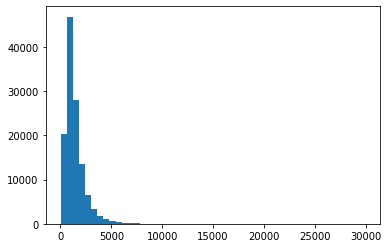

In [206]:
plt.hist(recipes_lengths, bins=50)
plt.show()

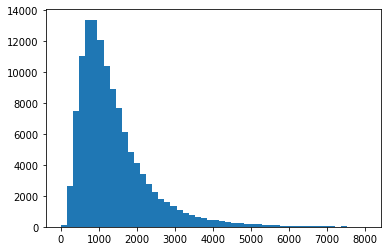

In [207]:
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [208]:
MAX_RECIPE_LENGTH = 2000
if DEBUG:
  MAX_RECIPE_LENGTH = 500

In [209]:
def filter_recipes_by_length(recipe_test):
  return len(recipe_test) <= MAX_RECIPE_LENGTH 

In [210]:
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of etiminated recipes: ', len(dataset_stringified) - len(dataset_filtered))

Dataset size BEFORE filtering:  122938
Dataset size AFTER filtering:  100212
Number of etiminated recipes:  22726


In [211]:
if DEBUG:
  dataset_filtered = dataset_filtered[:DEBUG_EXAMPLES]
  print('dataset_filtered.shape, ', len(dataset_filtered))

### Summarizing dataset parameters

In [212]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  2000
TOTAL_RECIPES_NUM:  100212


## Creating vocabulary

In [213]:
STOP_SIGN = '␣'

In [214]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [215]:
tokenizer.fit_on_texts([STOP_SIGN])

In [216]:
tokenizer.fit_on_texts(dataset_filtered)

In [217]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 100213,
 'word_counts': '{"\\u2423": 1, "\\ud83d\\udcd7": 100212, " ": 17527888, "S": 270259, "l": 3815150, "o": 5987496, "w": 964459, "C": 222831, "k": 890982, "e": 9296022, "r": 4760887, "h": 2922100, "i": 4911812, "c": 2883507, "n": 5304396, "a": 6067157, "d": 3099679, "D": 63999, "u": 2717050, "m": 1794411, "p": 2679164, "g": 1698670, "s": 4704222, "\\n": 1955281, "\\ud83e\\udd55": 100212, "\\u2022": 922813, "4": 232607, ",": 1130487, "b": 1394803, "t": 5997722, "v": 746785, "2": 493933, "(": 144985, "1": 853931, "0": 145119, ".": 1052548, "7": 31098, "5": 154071, ")": 144977, "f": 1042981, "y": 666553, "\\ud83d\\udcdd": 100212, "\\u25aa": 331058, "\\ufe0e": 331058, "P": 200597, "6": 51398, "H": 43936, "A": 134274, "3": 213519, "R": 101253, "x": 201286, "/": 345257, "I": 81591, "L": 46138, "8": 55352, "9": 17697, "B": 123813, "M": 78684, "F": 104359, "j": 1

In [218]:
# Adding +1 to take into account a special unassigned 0 index.
# @see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  176


In [219]:
print(tokenizer.index_word[5])
print(tokenizer.index_word[20])

o
,


In [220]:
tokenizer.word_index['r']

8

## Vectorizing the dataset

In [221]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)

In [222]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

In [223]:
print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 100212


In [224]:
print(dataset_vectorized[0][:10], '...')

[51, 1, 33, 10, 5, 23, 1, 35, 5, 5] ...


In [225]:
max_index_example = np.max(dataset_vectorized)

print('max_index_example: ', max_index_example)

max_index_example:  [51, 1, 97, 26, 1, 39, 2, 3, 1, 33, 3, 10, 3, 11, 1, 55, 5, 9, 4, 1, 50, 2, 57, 14, 2, 9, 4, 2, 11, 83, 16, 16, 52, 16, 16, 24, 1, 29, 1, 42, 26, 62, 1, 5, 14, 6, 13, 2, 43, 1, 15, 3, 13, 25, 3, 18, 2, 9, 1, 22, 8, 5, 46, 2, 6, 1, 15, 2, 4, 7, 4, 2, 1, 15, 2, 3, 9, 1, 16, 24, 1, 62, 1, 5, 14, 6, 13, 2, 9, 1, 9, 17, 5, 25, 2, 36, 22, 10, 3, 27, 5, 8, 2, 11, 1, 3, 10, 17, 5, 6, 11, 9, 20, 1, 22, 7, 6, 2, 10, 28, 1, 13, 12, 5, 15, 15, 2, 11, 1, 16, 24, 1, 26, 1, 5, 6, 7, 5, 6, 20, 1, 22, 7, 6, 2, 10, 28, 1, 13, 12, 5, 15, 15, 2, 11, 1, 16, 24, 1, 26, 1, 13, 14, 15, 1, 17, 3, 28, 5, 6, 6, 3, 7, 9, 2, 20, 1, 5, 8, 1, 17, 5, 8, 2, 1, 4, 5, 1, 4, 3, 9, 4, 2, 1, 16, 24, 1, 18, 8, 5, 14, 6, 11, 1, 19, 10, 3, 13, 25, 1, 15, 2, 15, 15, 2, 8, 1, 4, 5, 1, 4, 3, 9, 4, 2, 1, 16, 16, 53, 16, 16, 31, 32, 1, 39, 10, 3, 13, 2, 1, 22, 8, 5, 46, 2, 6, 1, 15, 2, 3, 9, 1, 7, 6, 1, 3, 1, 13, 5, 10, 3, 6, 11, 2, 8, 56, 1, 8, 7, 6, 9, 2, 1, 14, 6, 11, 2, 8, 1, 13, 5, 10, 11, 1, 23, 3, 4, 2, 

In [226]:
recipe_sequence_to_string(dataset_vectorized[0])

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



### Add padding to sequences

In [227]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 546
Recipe #2 length: 401
Recipe #3 length: 671
Recipe #4 length: 736
Recipe #5 length: 1518
Recipe #6 length: 740
Recipe #7 length: 839
Recipe #8 length: 667
Recipe #9 length: 1264
Recipe #10 length: 854


In [228]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure that all recipes will have at least 1 stops
    # sign at the end, since each sequence will be shifted and truncated afterwards (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [229]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [230]:
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001
Recipe #5 length: 2001
Recipe #6 length: 2001
Recipe #7 length: 2001
Recipe #8 length: 2001
Recipe #9 length: 2001


In [231]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [232]:
max_index_example = np.max(dataset_vectorized_padded)

print('max_index_example: ', max_index_example)

max_index_example:  175


### Create TensorFlow dataset 

In [233]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (2001,), types: tf.int32>


In [234]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 51   1  33 ... 165 165 165] 



Stringified recipe:

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

### Split examples on `input` and `target` texts

For each sequence, duplicate and shift it to form the input and target text. For example, say sequence_length is 4 and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [235]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

In [236]:
dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset shapes: ((2000,), (2000,)), types: (tf.int32, tf.int32)>


In [237]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 2000
Target sequence size: 2000

Input:   '📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e'
Target:  '  S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e s'


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for `[` and tries to predict the index for `T` as the next character. At the next time-step, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [238]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 51 ('📗')
  expected output: 1 (' ')
Step  2
  input: 1 (' ')
  expected output: 33 ('S')
Step  3
  input: 33 ('S')
  expected output: 10 ('l')
Step  4
  input: 10 ('l')
  expected output: 5 ('o')
Step  5
  input: 5 ('o')
  expected output: 23 ('w')
Step  6
  input: 23 ('w')
  expected output: 1 (' ')
Step  7
  input: 1 (' ')
  expected output: 35 ('C')
Step  8
  input: 35 ('C')
  expected output: 5 ('o')
Step  9
  input: 5 ('o')
  expected output: 5 ('o')
Step 10
  input: 5 ('o')
  expected output: 25 ('k')


### Split up the dataset into batches

In [239]:
print(dataset_targeted)

<MapDataset shapes: ((2000,), (2000,)), types: (tf.int32, tf.int32)>


In [240]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  100212
MAX_RECIPE_LENGTH:  2000
VOCABULARY_SIZE:  176


In [241]:
# Batch size.
BATCH_SIZE = 64

if DEBUG:
  BATCH_SIZE = DEBUG_EXAMPLES

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

if DEBUG:
  SHUFFLE_BUFFER_SIZE = 1

In [242]:
if DEBUG:
  dataset_train = dataset_targeted \
    .repeat() \
    .batch(BATCH_SIZE, drop_remainder=True)
else:
  dataset_train = dataset_targeted \
      .shuffle(SHUFFLE_BUFFER_SIZE) \
      .batch(BATCH_SIZE, drop_remainder=True) \
      .repeat()

print(dataset_train)

<RepeatDataset shapes: ((64, 2000), (64, 2000)), types: (tf.int32, tf.int32)>


In [243]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 51   1  49 ... 165 165 165]
 [ 51   1  39 ... 165 165 165]
 [ 51   1  55 ... 165 165 165]
 ...
 [ 51   1  59 ... 165 165 165]
 [ 51   1  35 ... 165 165 165]
 [ 51   1  33 ... 165 165 165]], shape=(64, 2000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  1  49   3 ... 165 165 165]
 [  1  39  14 ... 165 165 165]
 [  1  55   5 ... 165 165 165]
 ...
 [  1  59  12 ... 165 165 165]
 [  1  35   8 ... 165 165 165]
 [  1  33   2 ... 165 165 165]], shape=(64, 2000), dtype=int32)


## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this experiment we will use the following layer types:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [244]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[8 2 8 1 3 7 8 7]
 [5 4 5 8 4 7 6 6]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 1.29014738e-02  3.14478017e-02 -4.57828641e-02  7.61796162e-03
   -1.23929605e-02]
  [ 4.99065965e-03  1.24851950e-02 -3.89345400e-02  4.67981957e-02
    1.63230412e-02]
  [ 1.29014738e-02  3.14478017e-02 -4.57828641e-02  7.61796162e-03
   -1.23929605e-02]
  [-3.12451608e-02 -3.89479771e-02 -4.91791628e-02  1.42713226e-02
    2.80483477e-02]
  [-7.71000236e-03 -1.55376084e-02  5.10327518e-05  2.91767232e-02
   -4.93517295e-02]
  [ 2.99804285e-03  2.29802765e-02  3.25031541e-02 -4.19244543e-02
    2.26711966e-02]
  [ 1.29014738e-02  3.14478017e-02 -4.57828641e-02  7.61796162e-03
   -1.23929605e-02]
  [ 2.99804285e-03  2.29802765e-02  3.25031541e-02 -4.19244543e-02
    2.26711966e-02]]

 [[-6.90394640e-03  3.35142724e-02 -4.33147065e-02  1.12773106e-03
   -3.77704725e-02]
  [-1.26680359e-02  1.40046142e-02 -1.79053061e-02 -5.87247312e-04
    2.591

### Model 1

In [245]:
# Length of the vocabulary in chars.
vocab_size = VOCABULARY_SIZE

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [278]:
def build_model_1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

In [279]:
model_1 = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

model_1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (64, None, 256)           45056     
_________________________________________________________________
lstm_6 (LSTM)                (64, None, 1024)          5246976   
_________________________________________________________________
dense_5 (Dense)              (64, None, 176)           180400    
Total params: 5,472,432
Trainable params: 5,472,432
Non-trainable params: 0
_________________________________________________________________


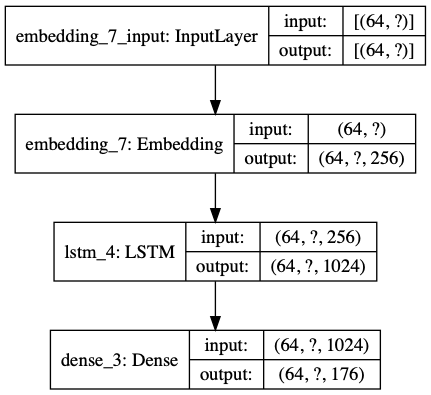

In [248]:
tf.keras.utils.plot_model(
    model_1,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_1.png'
)

For each character the model looks up the embedding, runs the LSTM one time-step with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Model architecture](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

## Trying the model

In [249]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model_1(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 2000, 176) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [250]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-2.9885047e-03 -8.1335875e-04 -4.1549057e-03 -1.8413543e-03
 -9.5993106e-04 -2.0468435e-03 -9.9845848e-04  2.5543855e-03
  2.2493873e-03  3.1810706e-03  6.1125739e-04  1.9313695e-03
  3.0768123e-03 -7.6538008e-03  2.0954923e-03 -4.4144504e-03
 -2.8546958e-04 -2.6842207e-03 -5.5518383e-03 -1.0367149e-03
 -9.4078173e-04  2.0151371e-03  9.5000397e-04 -2.5919646e-03
  2.9352750e-03  4.4975402e-03 -3.5304944e-03  6.3535990e-03
  3.9942341e-04  2.2782339e-03 -1.8489149e-03  1.9260517e-03
 -3.1928360e-03 -2.9373388e-03  2.8756014e-03  3.3351686e-03
  7.7729998e-04 -2.1016274e-03  4.5413058e-03 -9.6723880e-04
  5.2906685e-03 -2.8273968e-03  6.1267903e-03  1.3919600e-03
 -7.3972042e-05 -3.1386740e-03 -2.8877840e-03 -4.0053874e-03
 -4.7304099e-03  3.8110248e-03  6.0116742e-03  1.9332501e-03
 -1.3194481e-03  4.7730226e-03 -3.7076673e-03 -1.9218788e-03
  3.0248361e-03  2.9567287e-03  6.0534794e-03 -7.7213743e-03
 -2.5432804e-03 -

In [251]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 1 2 1]], shape=(1, 5), dtype=int64)


In [252]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([2000, 1])

In [253]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(2000,)

In [254]:
sampled_indices[:100]

array([ 21, 118,  21, 118, 126, 172, 112,   2,   5, 145,  18,  87, 172,
        66, 161,  57, 143, 175,   2,  55, 163,   5,  47,   6, 146, 113,
       156, 108,  65,  13,  65,  85, 105,  60,  13,  39,  43, 103, 169,
       143,   6, 139,  51, 132,  75,  15,  56, 103, 105, 149, 174,   2,
       118, 169,   7, 128, 126, 130,  77,  59,  42,  24, 115,  39,  89,
        73,  86, 175,  14,  77, 164,  94, 168, 154,   0,   7,  67, 161,
       118,  58, 157, 115, 167, 173,  62, 157, 156,  24,  90,  30,  31,
        34, 172, 105, 147,  11, 117, 154,   6, 165])

In [255]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '📗   M o l a s s e s   S u g a r   C o o k i e s \n \n 🥕 \n \n •   1   1 / 2   c u p s   s h o r t e n i'

Next char prediction:
 '. ê . ê ⁄ ⅞ ï e o ‱ g % ⅞ 7 \x92 q \\ \x95 e M ‒ o j n “ É \x1a < : c : – + 8 c P ) © ơ \\ n ˚ 📗 ö J p ; © + ⅛'


### Trying the model with variable input

In [256]:
for input_example_batch_custom, target_example_batch_custom in dataset_train.take(1):
    random_input = np.zeros(shape=(BATCH_SIZE, 10))
    example_batch_predictions_custom = model_1(random_input)
    print('Prediction shape: ', example_batch_predictions_custom.shape, "# (batch_size, sequence_length, vocab_size)\n")
    print('Custom length input: ')
    print(random_input)

Prediction shape:  (64, 10, 176) # (batch_size, sequence_length, vocab_size)

Custom length input: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0

## Training the model

### Attach an optimizer, and a loss function

In [280]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 2000, 176)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 2000)
scalar_loss:       5.1698756


In [281]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configuring checkpoints

In [259]:
# !rm -rf './tmp/checkpoints'

In [260]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [261]:
def download_latest_checkpoint(zip_only=True):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    latest_checkpoint_zip_name = latest_checkpoint_name + '.zip'
    
    print('latest_checkpoint_path: ', latest_checkpoint_path)
    print('latest_checkpoint_name: ', latest_checkpoint_name)
    print('---\n')

    print('Checkpoint files:')
    with zipfile.ZipFile(latest_checkpoint_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(checkpoint_dir):
            for filename in filenames:
                if filename.startswith(latest_checkpoint_name):
                        print('  - ' + filename)
                        file_path = os.path.join(folder_name, filename)
                        zip_obj.write(file_path, os.path.basename(file_path))
    print('---\n')
    print('Zipped to: ', latest_checkpoint_zip_name)

    if not zip_only:
        files.download(latest_checkpoint_zip_name)

In [262]:
def model_weights_from_latest_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Using model as is.')
        return model

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    return model

In [263]:
def initial_epoch_from_latest_checkpoint():
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Starting from epoch #0')
        return 0

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('latest_checkpoint_name: ', latest_checkpoint_name)

    latest_checkpoint_num = latest_checkpoint_name.split('_')[-1]
    print('latest_checkpoint_num: ', latest_checkpoint_num)

    return int(latest_checkpoint_num)

In [264]:
def unzip_checkpoint(checkpoint_zip_path):
    if not os.path.exists(checkpoint_zip_path):
        print('Cannot find a specified file')
        return

    os.makedirs(checkpoint_dir, exist_ok=True)
    with zipfile.ZipFile(checkpoint_zip_path, 'r') as zip_obj:
        zip_obj.extractall(checkpoint_dir)

    %ls -la ./tmp/checkpoints

In [0]:
# Unzip uploaded checkpoint to checkpoints folder if needed
# unzip_checkpoint('ckpt_10.zip')

In [0]:
# Loading the latest training data from checkpoints if needed.
# model_1 = model_weights_from_latest_checkpoint(model_1)

In [282]:
# Loading weights from H5 file if needed.
model_1.load_weights('recipe_generation_rnn_raw_8.h5')

### Configuring callbacks

In [275]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [276]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [268]:
INITIAL_EPOCH  = initial_epoch_from_latest_checkpoint()
EPOCHS_DELTA = 1
EPOCHS = INITIAL_EPOCH + EPOCHS_DELTA
STEPS_PER_EPOCH = 1000

print('\n')
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('EPOCHS_DELTA:    ', EPOCHS_DELTA)
print('EPOCHS:          ', EPOCHS)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

latest_checkpoint_path:  tmp/checkpoints/ckpt_1
latest_checkpoint_name:  ckpt_1
latest_checkpoint_num:  1


INITIAL_EPOCH:    1
EPOCHS_DELTA:     1
EPOCHS:           2
STEPS_PER_EPOCH:  1000


In [283]:
# history_1 = {}
history_1 = {} if not history_1 else history_1
print(history_1)

{1: <tensorflow.python.keras.callbacks.History object at 0x147c7f050>}


In [284]:
history_1[INITIAL_EPOCH] = model_1.fit(
    x=dataset_train,
    epochs=1,
    steps_per_epoch=1,
    initial_epoch=0,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

Train for 1 steps
1/1 [==============================] - 222s 222s/step - loss: 0.2727


In [88]:
print(history_1)

{}


### Downloading latest checkpoint

In [89]:
# Download zipped latest checkpoint to local drive.
download_latest_checkpoint(zip_only=True)

latest_checkpoint_path:  tmp/checkpoints/ckpt_1
latest_checkpoint_name:  ckpt_1
---

Checkpoint files:
  - ckpt_1.data-00000-of-00002
  - ckpt_1.index
  - ckpt_1.data-00001-of-00002
---

Zipped to:  ckpt_1.zip


In [0]:
model_name = 'recipe_generation_rnn_raw_1.h5'
model_1.save(model_name, save_format='h5')

### Visualizing training progress

In [0]:
def render_training_history(training_history):
    if 'history' in training_history:
        loss = training_history.history['loss']
    else:
        loss = []
        for initial_epoch in training_history:
            loss += training_history[initial_epoch].history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

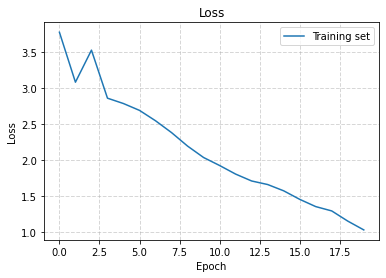

In [98]:
render_training_history(history_1)

## Generating text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [99]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_20'

In [0]:
simplified_batch_size = 1

model_1_simplified = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)

model_1_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_1_simplified.build(tf.TensorShape([simplified_batch_size, None]))

In [101]:
model_1_simplified.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            18176     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 71)             72775     
Total params: 5,337,927
Trainable params: 5,337,927
Non-trainable params: 0
_________________________________________________________________


In [102]:
model_1_simplified.input_shape

(1, None)

### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Prediction loop](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

In [0]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [104]:
generated_text = generate_text(
    model_1_simplified,
    start_string='O',
    num_generate = 800,
    temperature=1
)

print(generated_text)

📗 Oqurkokboktonnedserses.
▪︎ Miok in High ux talti, toro for cores.
▪︎ Coor Coon ghersh frith pot 3 an supt.
▪︎ Coukter and oleato, toop soinl 5 ox on inte.
␣︎ Ard ook oniin sot th gabrurl.
▪␣︎ Add cookil, draug 

📝4 1 ceaspoon migand ondit 

📝

▪︎ In a m cutk, inl six thegher and cores, onte ding a ded.
␣I︎ Add or mice sogh bore for souch rat togo. Sters in ceas, garinet 1/4 tesas ond filan onl pror sont in tout 1 ton oon sher sofl dady gart ting Pop umlash on coupt.
▪︎ Sive janos wim sow 4 anomo, mioni) slaup crgalon hicke, vof crestiy mfor ate sltounth gitl and or watvers, gbaike sori, inga blow sheppad avd ind gsup bed suth ton mabd ow orle salig untio talter mowucl and cryes ind and usp.📝

▪︎ Mice croene an and goup 5 tous 
• 1 4 oun ther anoo 
• 1 teaspoo mad migat 
• 1 teasp puptlg orp


In [105]:
generated_text = generate_text(
    model_1_simplified,
    start_string='O',
    num_generate = 800,
    temperature=0.5
)

print(generated_text)

📗 O8iukcw,oe ruced prepend jaded 
• 1 cup miganin 
• 2 cup poras 
• 1 unceasp ond copterser 

📝

▪︎ Pal cutte mix togher tout and oum sup moum soth cute sat in ad malom. Stor in con sant gher and malll. Mix in chersan atesh on and sales.
▪︎ Cook rong on the shiok 3 tor on cow sor sox tor 8 tous hoon sor satter and crisk w thir and sarl sarl cow smix tor for 5 houn soun 
• 1 teacep parced ond pepper 
• 1/4 cup pinn cow presp cup and saup 
• 1 (8 ounce) paran chaed dese freas 
• 1 (10.75 ounce) cann ganded 
• 1 tals boups, on cofond sorsin sarve sar buthe.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣


In [106]:
generated_text = generate_text(
    model_1_simplified,
    start_string='A',
    num_generate = 800,
    temperature=1.0
)

print(generated_text)

📗 A-ddye📗ark,. 3
2 1/al. Poun crile Po prowicer, an bumsiln, sedir show garlas Worenses, inc inpe santerind sar.a silig, acon art folat on at9 ond 5ariuse sim wlicttaro sthow aty on; sodr.␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣


In [107]:
generated_text = generate_text(
    model_1_simplified,
    start_string='A',
    num_generate = 800,
    temperature=.5
)

print(generated_text)

📗 Abklekspeedy poneded 
• 1/4 cup conded 
• 1/2 tap poppon porp prowt 
• 1 (1 ounce) pank gara ded cheese 
• 1 (8 oup cans and sow 
• 1 teaspoon sill conped rral 
• 1/4 tepporo fonil 
• 

📝
▪︎ In a smiok wige, mix theam math sous, soun 
• 1 teacesp onind sarpin 
• 1 tates on milasl and poppere sarl saud 
• 1 teas ponn bars 
• 1 teaspoon sal cup cresher 

📝

▪︎ In a m bowllo, mix togath the bares, ond sarped Workessher sar chees. Pare mix therator and cow sow sow ser toon in all and satte satl bers..␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣


In [108]:
generated_text = generate_text(
    model_1_simplified,
    start_string='Awesome',
    num_generate = 800,
    temperature=1
)

print(generated_text)

📗 Awesome
📝
▪
▪␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣Z␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣ ␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣


## Save the model

In [0]:
model_name = 'recipe_generation_rnn.h5'
model_1_simplified.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/recipe_generation_rnn/recipe_generation_rnn.h5 \
  ./demos/public/models/recipe_generation_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.